## 2022-02-20: Distributions of Inner Products in $\mathbb{R}^n$

*Last Updated*: 2022-02-20

### Authors
* Kevin Chu (kevin@velexi.com)

### Overview
In this Jupyter notebook, we investigate the distribution of the inner product of vectors drawn from a uniform distribution over a unit hypersphere in $\mathbb{R}^n$.

### Methodology

* Draw `sample_size` sets of $m$ vectors from a multivariate normal distribution with unit covariance matrix.

    * Using a multivariate normal distribution with diagonal covariance matrix ensures that vectors are drawn uniformly over directions.
    
    * To obtain a sample on the unit hypersphere, we normalize samples drawn from the multivariate normal distribution to have unit length.

### User Parameters

* `sample_size`: number of samples to use for estimating probability distributions

In [1]:
# --- User Parameters

# Number of samples to use to estimate probability distributions
sample_size = 1000;

In [2]:
# --- Imports

import Distributions
using Distributions: MvNormal, ContinuousUnivariateDistribution, cdf
using HypothesisTests
using LinearAlgebra
using Plots
using Random
using StatsBase: Histogram, fit

In [3]:
# --- Internal Parameters

# ------ Uniformity test parameters

# p-value cutoff
p_value_cutoff = 0.1;

# maximum number of attempts to generate a sample of vectors
max_attempts = 10;

### Utility Functions

In [4]:
# --- Probability distribution for θ (angle between vector and x_1-axis)

struct ThetaDistribution <: ContinuousUnivariateDistribution
    n::Integer
end

function Distributions.cdf(dist::ThetaDistribution, x::Real)
    # Preparations
    k = dist.n-2

    # Compute pdf
    value = 0
    if k % 2 == 0
        # Precompute re-used coefficients
        sgn = (-1)^(k÷2)
        k_choose_k_over_2 = binomial(big(k), k÷2)
        
        for j = 0:(k÷2 - 1)
            value += (-1)^j * binomial(big(k), j) * sin((k - 2*j) * x) / (k - 2*j)
        end
        value *= 2
        value += sgn * k_choose_k_over_2 * x  # contribution from i = k÷2 term
        value *= sgn / π / k_choose_k_over_2

    else
        normalization = 0
        for j = 0:(k-1)÷2
            
            coef = (-1)^j * binomial(big(k), j) * (1 / (k - 2*j) - 1 / (2*j - k))
            value += coef * (1 - cos((k - 2*j) * x))
            normalization += coef
        end
        normalization = 0.5 / normalization
        value *= normalization

    end

    return value
end

# --- Tests

# 2D: cdf(x) = x / π
theta_dist_2d = ThetaDistribution(2)
for x = range(0, π; length=10)
    computed_cdf = cdf(theta_dist_2d, x)
    expected_cdf = x / π
    @assert (computed_cdf ≈ expected_cdf) "Expected: $(expected_cdf). Got: $(computed_cdf)"
end

# 3D: cdf(x) = 0.5 * (1 - cos(x))
theta_dist_3d = ThetaDistribution(3)
for x = range(0, π; length=10)
    computed_cdf = cdf(theta_dist_3d, x)
    expected_cdf = 0.5 * (1 - cos(x))
    @assert (computed_cdf ≈ expected_cdf) "Expected: $(expected_cdf). Got: $(computed_cdf)"
end

In [5]:
function generate_vectors(n::Integer, sample_size::Integer)::Tuple
    """
    Generate a sample of unit vectors in an n-dimensional space drawn from a uniform
    distribution over the surface of an unit n-sphere.

    Parameters
    ----------
    n: dimension of space

    sample_size: number of blades to include in sample
    
    Return values
    -------------
    vectors: sample of vectors
    
    uniformity_stats: results of tests for uniformity of sample on unit n-sphere
    """
    # --- Set up uniformity tests

    theta_dist = ThetaDistribution(n)
    AD_p_value = 0
    KS_p_value = 0

    # --- Generate sample of vectors

    num_attempts = 0
    vectors = undef
    while ( ((AD_p_value < p_value_cutoff) || (KS_p_value < p_value_cutoff)) &&
            (num_attempts < max_attempts) )

        # Generate new sample
        dist = MvNormal(zeros(n), ones(n))
        num_vectors = sample_size
        vectors = rand(dist, num_vectors)
        for i = 1:num_vectors
            vectors[:, i] /= norm(vectors[:, i])
        end

        # Perform test for uniformity on unit n-sphere
        thetas = map(i -> atan(norm(vectors[:, i][2:end]), vectors[:, i][1]), 1:num_vectors)

        # Anderson-Darling Test
        AD_p_value = pvalue(OneSampleADTest(thetas, theta_dist))

        # Kolmogorov-Smirnov Test
        KS_p_value = pvalue(ExactOneSampleKSTest(thetas, theta_dist))

        # Update attempt count
        num_attempts += 1
    end

    # --- Save uniformity test results

    uniformity_stats = (
        success=(num_attempts < max_attempts),
        num_attempts=num_attempts,
        AD_p_value=AD_p_value,
        KS_p_value=KS_p_value,
    )
    
    return vectors, uniformity_stats
end

generate_vectors (generic function with 1 method)

### Distributions in 2D

In [6]:
# --- Generate sample of vectors

# Dimension of space
n_2d = 2;

# Generate sample of vectors
vectors, uniformity_stats = generate_vectors(n_2d, sample_size)
if !uniformity_stats[:success]
    println("FAILED to generated sample with sufficient uniformity on unit circle.")
    display(uniformity_stats)
end

In [7]:
# --- Compute inner products

inner_products = Vector{Float64}()
for i = 1:sample_size
    vector_i = vectors[:, i]
    
    for j = 1:sample_size
        # Skip inner product of vector with itself
        if i == j
            continue
        end
            
        push!(inner_products, dot(vector_i, vectors[:, j]))
    end
end

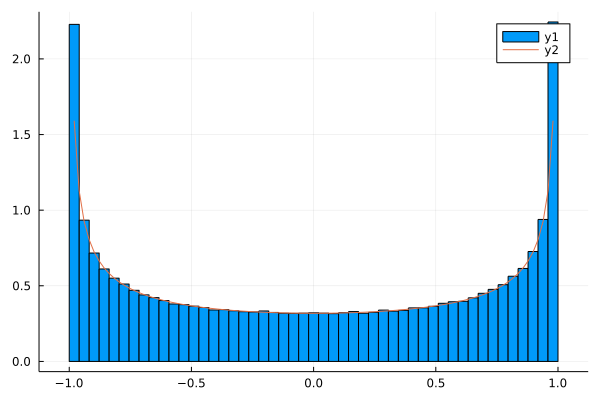

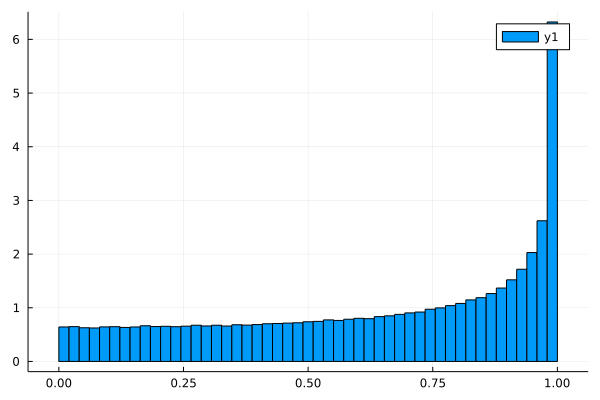

In [8]:
# --- Compute distributions

# Analytical PDF
pdf_2d(x) = 1 / π / sqrt(1 - x^2)

# Histogram parameters
num_hist_bins = 50

# Plot histograms
hist_bins = range(-1, 1; length=num_hist_bins)
plt = plot(histogram(inner_products; bins=hist_bins, normalize=true))
plot!(pdf_2d, range(-1, 1; length=100))

hist_bins_abs = range(0, 1; length=num_hist_bins)
abs_inner_products = abs.(inner_products)
plt_abs = plot(histogram(abs_inner_products; bins=hist_bins_abs, normalize=true))

display(plt)
display(plt_abs)

# Compute empirical volume distributions
hist = fit(Histogram, inner_products; nbins=num_hist_bins)
edf = normalize(hist; mode=:pdf);

hist_abs = fit(Histogram, abs_inner_products; nbins=num_hist_bins)
edf_abs = normalize(hist; mode=:pdf);

### Distributions in 3D

In [9]:
# --- Generate sample of vectors
# Dimension of space
n_3d = 3;

# Generate sample of vectors
vectors, uniformity_stats = generate_vectors(n_3d, sample_size)
if !uniformity_stats[:success]
    println("FAILED to generated sample with sufficient uniformity on unit sphere.")
    display(uniformity_stats)
end

In [10]:
# --- Compute inner products

inner_products = Vector{Float64}()
for i = 1:sample_size
    vector_i = vectors[:, i]
    
    for j = 1:sample_size
        # Skip inner product of vector with itself
        if i == j
            continue
        end
            
        push!(inner_products, dot(vector_i, vectors[:, j]))
    end
end

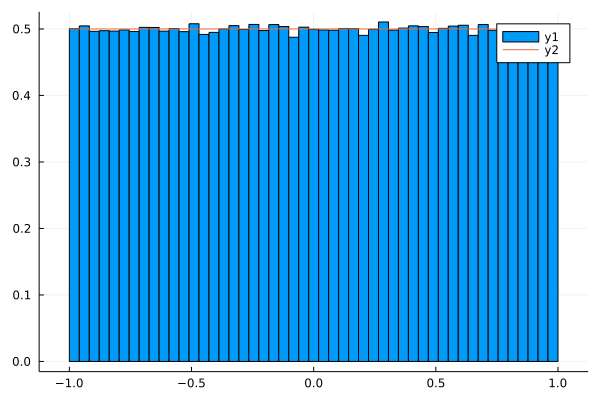

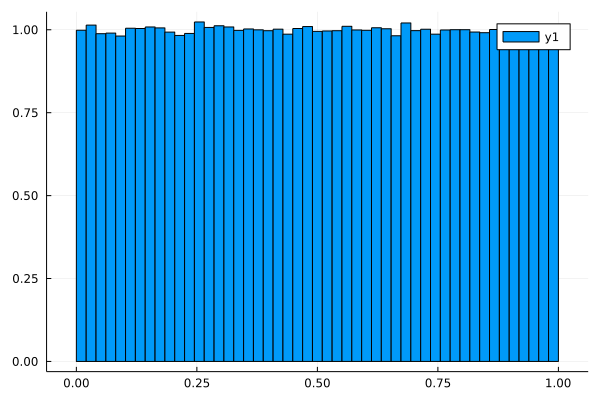

In [11]:
# --- Compute distributions

# Analytical PDF
pdf_3d(x) = 0.5

# Histogram parameters
num_hist_bins = 50

# Plot histograms
hist_bins = range(-1, 1; length=num_hist_bins)
plt = plot(histogram(inner_products; bins=hist_bins, normalize=true))
plot!(pdf_3d, range(-1, 1; length=100))

hist_bins_abs = range(0, 1; length=num_hist_bins)
abs_inner_products = abs.(inner_products)
plt_abs = plot(histogram(abs_inner_products; bins=hist_bins_abs, normalize=true))

display(plt)
display(plt_abs)

# Compute empirical volume distributions
hist = fit(Histogram, inner_products; nbins=num_hist_bins)
edf = normalize(hist; mode=:pdf);

hist_abs = fit(Histogram, abs_inner_products; nbins=num_hist_bins)
edf_abs = normalize(hist; mode=:pdf);

### Distributions in Arbitrary Dimensions

In [12]:
# --- Generate sample of vectors

# Dimension of space
n = 100;

# Generate sample of vectors
vectors, uniformity_stats = generate_vectors(n, sample_size)
if !uniformity_stats[:success]
    println("FAILED to generated sample with sufficient uniformity on unit $(n)-sphere.")
    display(uniformity_stats)
end

In [13]:
# --- Compute inner products

inner_products = Vector{Float64}()
for i = 1:sample_size
    vector_i = vectors[:, i]
    
    for j = 1:sample_size
        # Skip inner product of vector with itself
        if i == j
            continue
        end
            
        push!(inner_products, dot(vector_i, vectors[:, j]))
    end
end

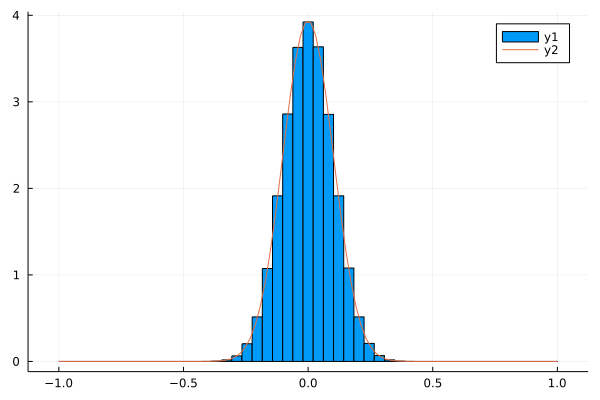

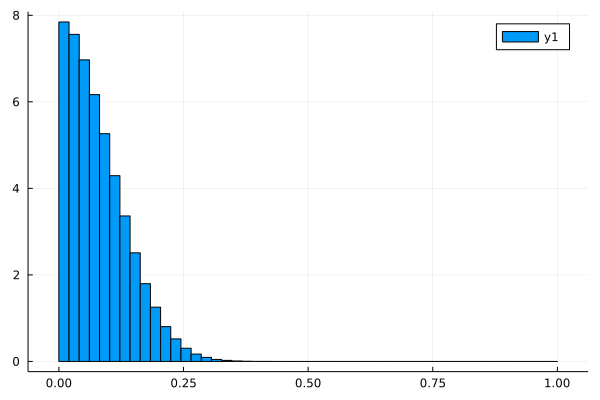

In [14]:
# --- Compute distributions

# ------ Analytical PDF: proportional to (sin(θ))^(n-3)

# Compute normalization factor
k = n - 3
if k % 2 == 0
    norm_ = 1 / π
else
    norm_ = 0
    for j = 0:(k-1)÷2
        norm_ += (-1)^j * binomial(big(k), j) / (k - 2*j)
    end
    norm_ *= 4
    norm_ = abs(norm_)
end
pdf_nd(x) = (2^big(k) / norm_) * (1 - x^2)^(k/2)

# Histogram parameters
num_hist_bins = 50

# Plot histograms
hist_bins = range(-1, 1; length=num_hist_bins)
plt = plot(histogram(inner_products; bins=hist_bins, normalize=true))
plot!(pdf_nd, range(-1, 1; length=100))

hist_bins_abs = range(0, 1; length=num_hist_bins)
abs_inner_products = abs.(inner_products)
plt_abs = plot(histogram(abs_inner_products; bins=hist_bins_abs, normalize=true))

display(plt)
display(plt_abs)

# Compute empirical volume distributions
hist = fit(Histogram, inner_products; nbins=num_hist_bins)
edf = normalize(hist; mode=:pdf);

hist_abs = fit(Histogram, abs_inner_products; nbins=num_hist_bins)
edf_abs = normalize(hist; mode=:pdf);